## Initialization: Import devices, modules and start station

In [1]:
import sys
sys.path.append('C:/QCodes drivers and scripts/Drivers')

from PLH250P_current_source_dummy import TTi
from PLH250P_current_source_TCP import current_set,power_up as current_source_on,power_down as current_source_off
current_source = TTi('TTi')

# import MS46522B_KRA_VNA_arnitzu as VNA_Anritsu
# vna_gvf= VNA_Anritsu.MS46522B('VNA', 'TCPIP::192.168.0.52',  init_s_params=False)
# vna_gvf.add_channel('S21')

import VNA_Anritsu as VNA_Anritsu
vna_gvf= VNA_Anritsu.MS46522B('VNA', 'TCPIP::192.168.0.52',  init_s_params=False)
vna_gvf.add_channel('S21')

from RS_SMB_100A import SMB100A
MW_source_1_gvf = SMB100A('SMB100A_1', 'TCPIP0::192.168.0.53::inst0::INSTR')
# MW_source_2_gvf = SMB100A('SMB100A_2', 'TCPIP0::192.168.0.54::inst0::INSTR')
# MW_source_3_gvf = SMB100A('SMB100A_3', 'TCPIP0::192.168.0.55::inst0::INSTR')

# from RS_FSQ import RS_FSQ|
# RS_SA_gvf = RS_FSQ('RS_FSQ', 'TCPIP0::192.168.0.61::inst0::INSTR')

Connected to: Dummy corp current source 001 (serial:dummy 100, firmware:None) in 0.00s
Connected to: ANRITSU MS46522B (serial:1728106, firmware:V2019.12.1,V3.3.12) in 0.09s
Connected to: Rohde&Schwarz SMB100A (serial:1406.6000k03/177960, firmware:3.1.18.2-3.01.203.32) in 0.02s


In [2]:
# print('Is the SNTJ grounded? (y/n)')

# warning = input()
# if warning == 'y':
#     from Yokogawa_7651 import Yokogawa_7651
#     Yokogawa_7651_SNTJ = Yokogawa_7651('Yokogawa_7651', 'GPIB0::4::INSTR')
#     # Yokogawa_7651_SNTJ = Yokogawa_7651('Yokogawa_7651', 'TCPIP0::192.168.1.253::gpib0::INSTR')

In [3]:
# Yokogawa_7651_SNTJ.voltage_range(100)
# Yokogawa_7651_SNTJ.voltage_limit(1000)
# Yokogawa_7651_SNTJ.current_limit(5)

# Yokogawa_7651_SNTJ.status('on')
# print('Success: SNTJ can be connected')

In [4]:
import sys
import qcodes as qc
from qcodes.logger.logger import start_all_logging
import datetime
from qcodes.dataset.plotting import plot_dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
# %matplotlib inline
#qcodes.config.subscription.default_subscribers = ["Plottr"]
from time import sleep

from pprint import pprint
import json

sys.path.append('C:\QCodes drivers and scripts\Scripts\Arpit\Modules')
from notify import snotify
from progress_barV2 import bar
from general_functions import find_nearest

In [5]:
start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.roch\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nicolas.roch\.qcodes\logs\220505-21640-qcodes.log


In [6]:
#create a station
station = qc.Station()
station.add_component(vna_gvf)
station.add_component(current_source)
station.add_component(MW_source_1_gvf)
# station.add_component(MW_source_2_gvf)
# station.add_component(MW_source_3_gvf)
#station.add_component(RS_SA_gvf)
# station.add_component(Yokogawa_7651_SNTJ)
station.snapshot()
station.components

{'VNA': <MS46522B: VNA>, 'TTi': <TTi: TTi>, 'SMB100A_1': <SMB100A: SMB100A_1>}

In [7]:
# Load experiment details
experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.json','r')
experiment = experiment_file.readlines()
experiment=json.loads(''.join(experiment))

user = experiment['details']['user']
# date = experiment['details']['date']
date = '-'.join(str(datetime.date.today()).split('-'))
description = experiment['details']['description']
cooldown = experiment['details']['cooldown']
database_name = date+"_"+'CD_'+cooldown+'_'+user+"_"+description
# print(database_name)
# database_name = '2021-11-03_CD_06_10_GC_RK TWPAs'

#Create or Initialize the database
qc.initialise_or_create_database_at("D:/Data_QCodes/"+database_name)
qc.config.core.db_location

'D:/Data_QCodes/2022-05-05_CD_05_05_GC_RK TWPA'

In [8]:
device_ids = experiment['device_ids']

In [9]:
# MW_source_3_gvf.status('on')

## Sweep Flux and acquire normalized VNA trace

In [10]:
parameter_snap={}

# Yokogawa 
# SNTJ_resistance = 54.
# v_shift = 30### uV
# SNTJ_voltage = (v_shift)*10/SNTJ_resistance 
# parameter_snap['SNTJ']={'SNTJ_resistance':SNTJ_resistance,'SNTJ_voltage':SNTJ_voltage}


# VNA
start_freq = 3
end_freq = 13
points_per_gigahz = 100
VNA_power = -10
IF_bandwidth = 1000
Averages = 1
points_VNA=1+(end_freq-start_freq)*points_per_gigahz
parameter_snap['vna']={'start_freq':start_freq,'end_freq':end_freq,'points_per_gigahz':points_per_gigahz,'VNA_power':VNA_power,'IF_bandwidth':IF_bandwidth,'Averages':Averages,'points':points_VNA}


# MW Source Pump
pump_frequency = 6
pump_power = 6.40
parameter_snap['pump']={'pump_frequency':pump_frequency,'pump_power':pump_power}


# Current source
I_start = -25
I_end = 25
I_step = 0.5
points_I= int(abs(I_end - I_start)/I_step)+1
parameter_snap['flux']={'I_start':I_start,'I_end':I_end,'I_step':I_step}


# Yokogawa_7651_SNTJ.voltage_range(100)
# Yokogawa_7651_SNTJ.voltage_limit(1000)
# Yokogawa_7651_SNTJ.current_limit(5)
# Yokogawa_7651_SNTJ.voltage(0)
# Yokogawa_7651_SNTJ.status('on')
# Yokogawa_7651_SNTJ.voltage(SNTJ_voltage)

MW_source_1_gvf.frequency(pump_frequency*1e9)
MW_source_1_gvf.power(pump_power)
MW_source_1_gvf.phase(0)

# MW_source_3_gvf.frequency(pump_frequency*1e9)
# MW_source_3_gvf.power(25)
# MW_source_3_gvf.phase(0)

current_set(I_start)

vna_gvf.channels.S21.bandwidth(IF_bandwidth)
vna_gvf.channels.S21.power(VNA_power)
vna_gvf.channels.S21.avg(Averages)
vna_gvf.channels.npts(points_VNA)
vna_gvf.channels.start(start_freq*1e9)
vna_gvf.channels.stop(end_freq*1e9)

# Initialize devices
vna_gvf.rf_on()
vna_gvf.cont_meas_on()
# current_source_on()
# MW_source_2_gvf.status('off')
# MW_source_3_gvf.status('off')
# set_rt_switch('NC')

states = ['off','on']
#states = ['on']
# states = ['off']

experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.json','r')
experiment = experiment_file.readlines()
experiment = json.loads(''.join(experiment))
switch_position = experiment['current_device']['current_device']

for pump in states:

    exp_name = 'Gain vs flux : pump '+pump
    sample_name = device_ids[switch_position]
    exp=qc.load_or_create_experiment(experiment_name=exp_name,
                              sample_name=sample_name)
    
    meas = qc.Measurement(exp=exp, station=station) 
    meas.register_parameter(current_source.current) 
    meas.register_parameter(vna_gvf.channels.S21.trace_mag_phase, setpoints=(current_source.current,)) 
    meas.write_period = 2

    with meas.run() as datasaver:
        MW_source_1_gvf.status(pump)
#         MW_source_3_gvf.status(pump)
        for I in bar(np.linspace(I_start, I_end, points_I)):
            I=round(I,2)
            current_set(I)
            get_v = vna_gvf.channels.S21.trace_mag_phase.get()
            datasaver.add_result((current_source.current, I),
                                 (vna_gvf.channels.S21.trace_mag_phase, get_v))
    id_num=datasaver.dataset.run_id
    qc.load_by_run_spec( captured_run_id=id_num).add_metadata('parameter_snap',json.dumps(parameter_snap))
            

            
# Shutdown devices
# vna_gvf.rf_off()
# vna_gvf.cont_meas_off()
# current_source_off()
# Yokogawa_7651_SNTJ.voltage(0)
MW_source_1_gvf.status('off')
# MW_source_3_gvf.status('off')
# snotify('arpit.ranadive@gmail.com','Finished: '+exp_name+' '+sample_name)

Starting experimental run with id: 2. 


Starting experimental run with id: 3. 


In [11]:
captured_run_id_off = id_num-1
captured_run_id_on = id_num
# captured_run_id_off = 11
# captured_run_id_on = 10
dataset_on = qc.load_by_run_spec(captured_run_id=captured_run_id_on)
dataset_off = qc.load_by_run_spec( captured_run_id=captured_run_id_off)

metadata = json.loads(dataset_on.get_metadata('parameter_snap'))
pprint(metadata)

{'flux': {'I_end': 25, 'I_start': -25, 'I_step': 0.5},
 'pump': {'pump_frequency': 6, 'pump_power': 6.4},
 'vna': {'Averages': 1,
         'IF_bandwidth': 1000,
         'VNA_power': -10,
         'end_freq': 13,
         'points': 1001,
         'points_per_gigahz': 100,
         'start_freq': 3}}


In [12]:
points_VNA = int(metadata['vna']['points'])
pump_frequency = float(metadata['pump']['pump_frequency'])
pump_power = float(metadata['pump']['pump_power'])

In [13]:
flux_data=list(dict.fromkeys(dataset_on.get_parameter_data('magnitude')['magnitude']['TTi_current']))

# points_VNA=int(metadata[metadata.find('"points"')+10:metadata.find("pump")-4])

freq_data=dataset_on.get_parameter_data('magnitude')['magnitude']['VNA_S21_S21_frequency'][0:points_VNA]*1e-9


magnitude_on=(dataset_on.get_parameter_data('magnitude')['magnitude']['magnitude']).reshape(len(flux_data),len(freq_data))

magnitude_off=(dataset_off.get_parameter_data('magnitude')['magnitude']['magnitude']).reshape(len(flux_data),len(freq_data))

<IPython.core.display.Javascript object>


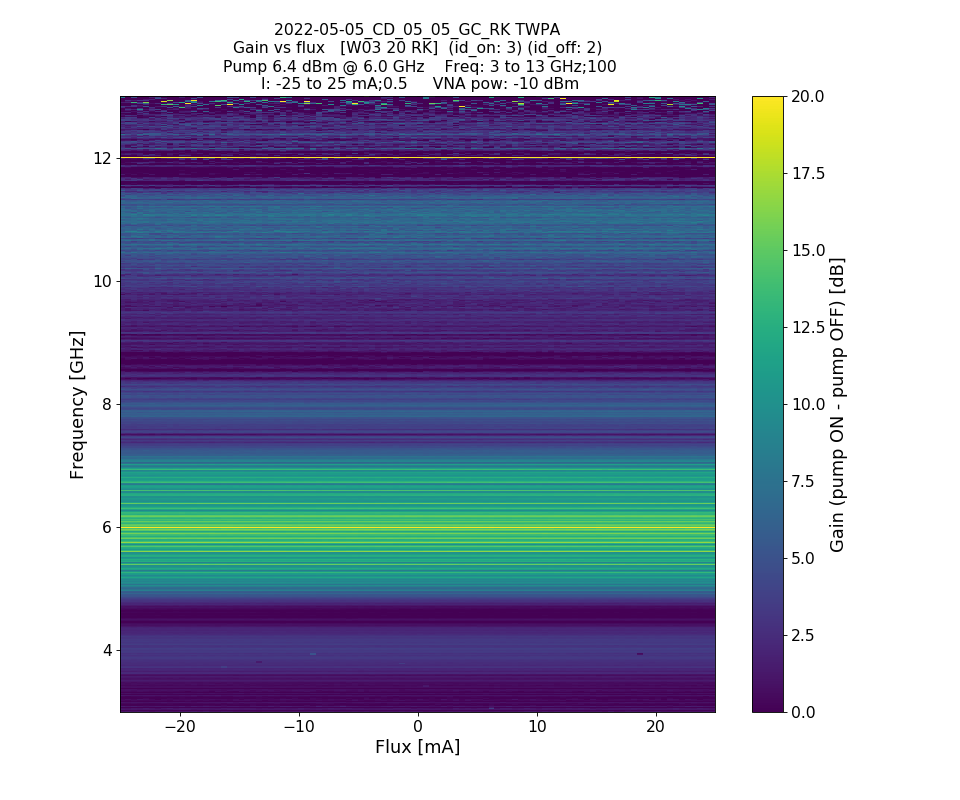

In [14]:
exp_name = dataset_on.exp_name
sample_name = dataset_on.sample_name

plot_title=database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
plot_title+='\n Pump '+str(pump_power)+' dBm @ '+str(round(pump_frequency,4))+' GHz    Freq: '+str(start_freq)+' to '+str(end_freq)+' GHz;'+str(points_per_gigahz)+'\n I: '+str(I_start)+' to '+str(I_end)+' mA;'+str(I_step)+'     VNA pow: '+str(VNA_power)+' dBm'

plt.figure(figsize=(12, 10), dpi= 80) #facecolor='w', edgecolor='k'

X, Y = np.meshgrid(np.array(flux_data),np.array(freq_data))
Z = (magnitude_on-magnitude_off).T
# Z = (magnitude_off).T
# Z = (magnitude_on).T
# plt.pcolor(X, Y, Z)
plt.pcolor(X, Y, Z, vmin=-0, vmax=20)
cbar=plt.colorbar()
cbar.set_label('Gain (pump ON - pump OFF) [dB]', size=16)
cbar.ax.tick_params(labelsize=14) 

plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.xticks(fontsize=14)    # fontsize of the tick labels
plt.yticks(fontsize=14) 

x_label='Flux [mA]'
y_label='Frequency [GHz]'
plt.xlabel(x_label, size=16)
plt.ylabel(y_label, size=16)
# plt.ylim(3, 10)
plt.title(plot_title, size=14)
x_value = 1.5
# plt.axvline(x_value, label = str(x_value), color = 'r')
# plt.legend()
# plt.axvline(0.2)

plt.show()

<IPython.core.display.Javascript object>


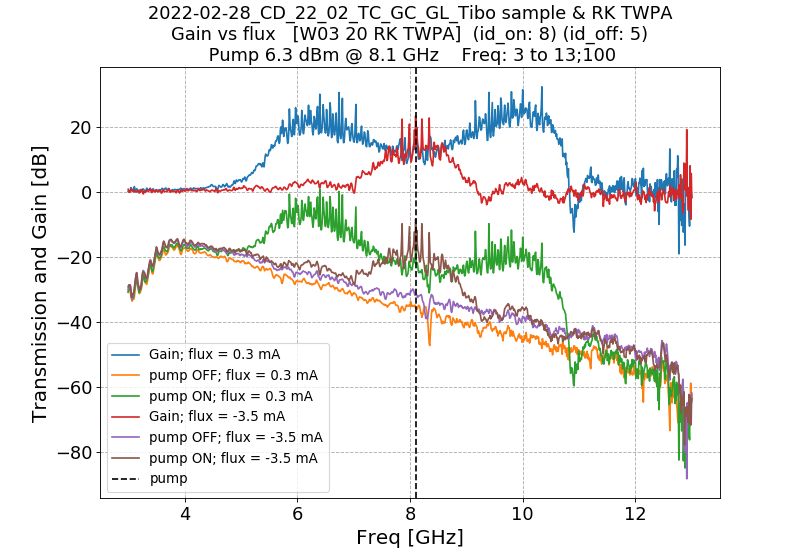

In [15]:
current_list=1*np.array([0.3, -3.5])
# current_list=1*np.array([6.2])
# current_list=1*np.array([10])

plot_title=database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
plot_title+='\n Pump '+str(pump_power)+' dBm @ '+str(pump_frequency)+' GHz    Freq: '+str(start_freq)+' to '+str(end_freq)+';'+str(points_per_gigahz)

gain=magnitude_on-magnitude_off

plt.figure(figsize=(10, 7), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Freq [GHz]'
y_label='Transmission and Gain [dB]'

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for current in current_list:
    plt.plot(freq_data,gain[find_nearest(flux_data,current)],label='Gain; '+'flux = '+str(current)+' mA')
    plt.plot(freq_data,magnitude_off[find_nearest(flux_data,current)],label='pump OFF; '+'flux = '+str(current)+' mA')
    plt.plot(freq_data,magnitude_on[find_nearest(flux_data,current)],label='pump ON; '+'flux = '+str(current)+' mA')#,label='pump_pow: '+str(pump_power)+' [dB]')#'I = '+str(current)+' mA')#marker="."
#     plt.fill_between(freq_data,gain[find_nearest(flux_data,current)], color = 'b', alpha=0.1)
#     plt.plot(freq_data_PSD,PSD[find_nearest(flux_data_PSD,current)],label='flux = '+str(current)+' mA')
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
# plt.title(plot_title, size=16)


plt.title(plot_title, size=16)
# delta = 0.1
# plt.axvline(pump_frequency-delta)
# plt.axvline(pump_frequency+delta)
# plt.axvline(pump_frequency+0.05)
# plt.axvline(pump_frequency-0.05)
plt.xlabel(x_label, size=18)
plt.ylabel(y_label, size=18)
plt.xticks(fontsize =16)
plt.yticks(fontsize =16)
plt.axvline(pump_frequency, color = 'k', linestyle = '--', label = 'pump')
# plt.axvline(2*pump_frequency, color = 'b', linestyle = '--',label = '2pump' )
# plt.axvline(0.5*pump_frequency, color = 'r', linestyle = '--',label = 'pump/2' )
# plt.xlim(7.5, 8.5)
# plt.ylim(-80, 35)
plt.legend(fontsize = 12)
plt.show()    

In [16]:
captured_run_id = 28

dataset = qc.load_by_run_spec(captured_run_id=captured_run_id)
exp_name=dataset.exp_name
dataset

data_PSD = dataset.get_parameter_data('RS_FSQ_spectrum')['RS_FSQ_spectrum']['RS_FSQ_spectrum']
freq_data_PSD = dataset.get_parameter_data('RS_FSQ_freq_axis')['RS_FSQ_freq_axis']['RS_FSQ_freq_axis'][0]*1e-9
flux_data_PSD = dataset.get_parameter_data('TTi_current')['TTi_current']['TTi_current']

parameter_snap=json.loads(dataset.get_metadata('parameter_snap'))

NameError: No run matching the supplied information found.

<IPython.core.display.Javascript object>


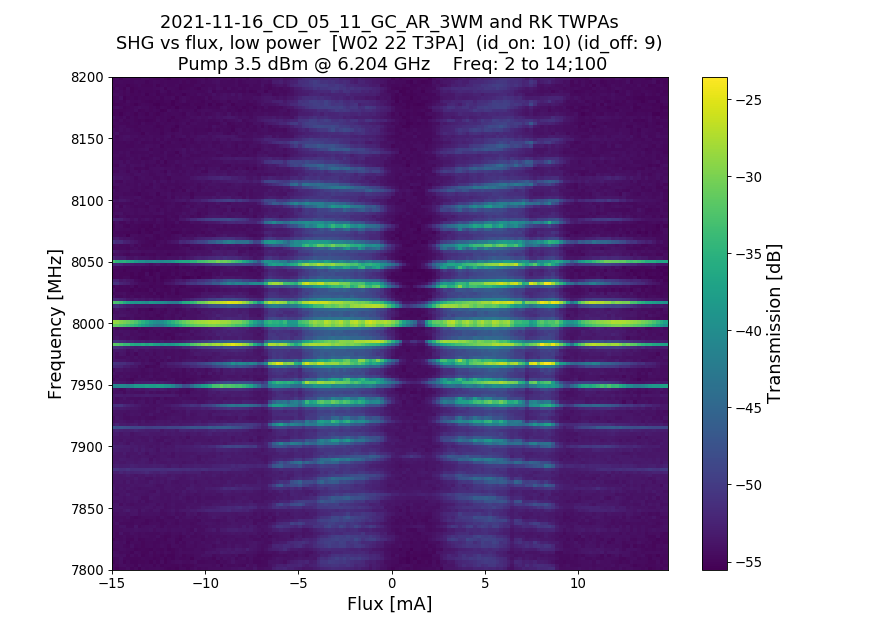

In [84]:
# plot_title=database_name+'\n'+exp_name+'  ['+sample_name+']  (id: '+str(captured_run_id)+')'
# plot_title+='\n Freq: '+str(start_freq*1e-9)+' to '+str(end_freq*1e-9)+' GHz; '+str(points)+'   I: '+str(I_start)+' to '+str(I_end)+' mA; '+str(I_step)+' step'
# plot_title += '\n tone power '+str(pump_power)+ ' dBm @ ' + str(pump_frequency) + ' GHz'


plt.figure(figsize=(14*0.8, 10*0.8), dpi= 80) #facecolor='w', edgecolor='k'

X, Y = np.meshgrid(np.array(flux_data_PSD),np.array(freq_data_PSD*1e3))
Z = data_PSD.T
plt.pcolor(X, Y, Z)
# plt.pcolor(X, Y, Z, vmin=-80, vmax=0-20)
# plt.axvline(-0.5, style='--')
cbar=plt.colorbar()
cbar.set_label('Transmission [dB]', size=16)

plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12*1.2)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12*1.2)  

x_label='Flux [mA]'
y_label='Frequency [MHz]'
plt.xlabel(x_label, size=16)
plt.ylabel(y_label, size=16)
plt.title(plot_title, size=16)
# plt.axvline(0.9)

plt.show()

<IPython.core.display.Javascript object>


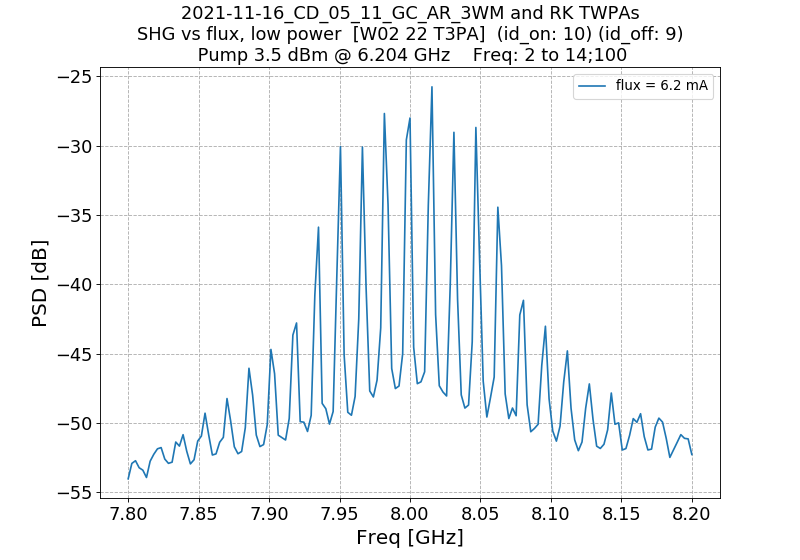

In [85]:
current_list=1*np.array([6.2])
# current_list=1*np.array([10])

# plot_title=database_name+'\n'+exp_name+'  ['+sample_name+']  (id: '+str(captured_run_id)+')'
# plot_title+='\n Freq: '+str(start_freq*1e-9)+' to '+str(end_freq*1e-9)+' GHz; '+str(points)+'   I: '+str(I_start)+' to '+str(I_end)+' mA; '+str(I_step)+' step'
# plot_title += '\n tone power '+str(pump_power)+ ' dBm @ ' + str(pump_frequency) + ' GHz'

PSD=data_PSD

plt.figure(figsize=(10, 7), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Freq [GHz]'
y_label='PSD [dB]'

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for current in current_list:
    plt.plot(freq_data_PSD,PSD[find_nearest(flux_data_PSD,current)],label='flux = '+str(current)+' mA')
    
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
# plt.title(plot_title, size=16)


plt.title(plot_title, size=16)
plt.xlabel(x_label, size=18)
plt.ylabel(y_label, size=18)
plt.xticks(fontsize =16)
plt.yticks(fontsize =16)
# plt.xlim(7.5, 8.5)
# plt.ylim(-80, 35)
plt.legend(fontsize = 12)
plt.show()    

In [57]:
np.save('V08-05-13-freq', freq_data)

In [58]:
np.save('V08-05-13-off', magnitude_off[find_nearest(flux_data,current)])

In [59]:
np.save('V08-05-13-on', magnitude_off[find_nearest(flux_data,current)])

In [17]:
%matplotlib notebook

<IPython.core.display.Javascript object>


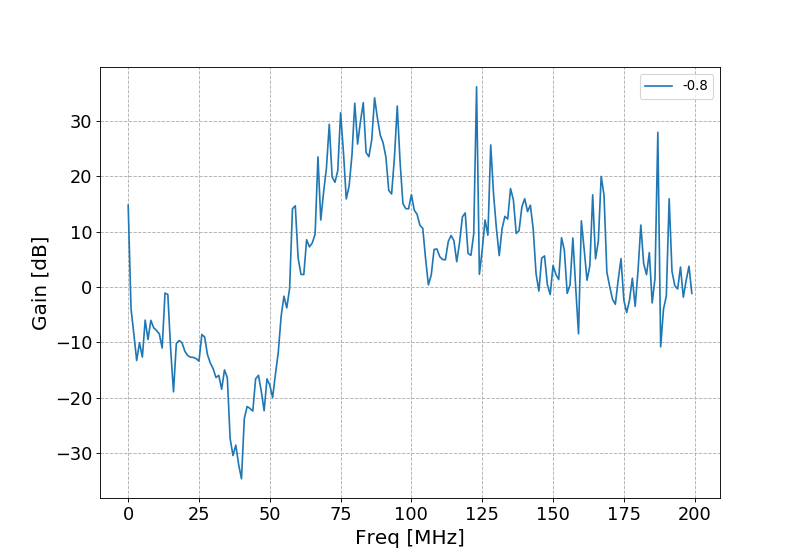

In [20]:
current = -0.8
index_max = 200
index_pump = find_nearest(freq_data,pump_frequency)

diff = []
for index in range(index_max):
    diff.append(gain[find_nearest(flux_data,current)][index_pump+index]-gain[find_nearest(flux_data,-8)][index_pump-index])
    
plt.figure(figsize=(10, 7), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Freq [MHz]'
y_label='Gain [dB]'

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

plt.plot(range(index_max),diff,label=str(current))

plt.legend(fontsize = 12)
# plt.axvline(pump_frequency-delta)
# plt.axvline(pump_frequency+delta)
plt.xlabel(x_label, size=18)
plt.ylabel(y_label, size=18)
plt.xticks(fontsize =16)
plt.yticks(fontsize =16)
# plt.xlim(2, 6)
# plt.ylim(-5, 28)
plt.show()

In [446]:
#sweep the pump frequency

nus_pump = [12.7]
#pump_pows = [7.0, 9.0, 11.0, 14.0, 14.0, 14.0, 15.0, 15.0, 19.0 ]


for k in range(len(nus_pump)):
    nu_pump = nus_pump[k]
    pump_power = 19.9#pump_pows[k]
    print('pump pow: ', pump_power, 'pump freq: ', nu_pump )
    parameter_snap={}
    # VNA
    start_freq=1.5
    end_freq=15
    points_per_gigahz=100
    VNA_power = -20
    IF_bandwidth=10
    Averages=1
    points_VNA=1+(end_freq-start_freq)*points_per_gigahz
    points_VNA=int(points_VNA)
    parameter_snap['vna']={'start_freq':start_freq,'end_freq':end_freq,'points_per_gigahz':points_per_gigahz,'VNA_power':VNA_power,'IF_bandwidth':IF_bandwidth,'Averages':Averages,'points':points_VNA}


    # MW Source Pump
    pump_frequency= nu_pump + 0.000005
    parameter_snap['pump']={'pump_frequency':pump_frequency,'pump_power':pump_power}

    # Current source
    I = -3.08
    parameter_snap['flux']={'I':I}

    MW_source_1_gvf.frequency(pump_frequency*1e9)
    MW_source_1_gvf.power(pump_power)
    MW_source_1_gvf.phase(0)

    vna_gvf.channels.S21.bandwidth(IF_bandwidth)
    vna_gvf.channels.S21.power(VNA_power)
    vna_gvf.channels.S21.avg(Averages)
    vna_gvf.channels.npts(points_VNA)
    vna_gvf.channels.start(start_freq*1e9)
    vna_gvf.channels.stop(end_freq*1e9)


    # Initialize devices
    vna_gvf.rf_on()
    vna_gvf.cont_meas_on()
    current_source_on()
    # MW_source_2_gvf.status('off')
    set_rt_switch('NC')


    for pump in ['off','on']:
    #for pump in ['on']:

        exp_name = 'Gain vs flux : pump '+pump
        sample_name = 'T3PA V08 02'
        exp=qc.load_or_create_experiment(experiment_name=exp_name,
                                  sample_name=sample_name)

        meas = qc.Measurement(exp=exp, station=station) 
        #meas.register_parameter(current_source.current) 
        meas.register_parameter(vna_gvf.channels.S21.trace_mag_phase) 
        meas.write_period = 2

        with meas.run() as datasaver:
            MW_source_1_gvf.status(pump)
    #         MW_source_3_gvf.status(pump)
            #for I in bar(np.linspace(I_start, I_end, points_I)):
            I=round(I,2)
            current_set(I)
            get_v = vna_gvf.channels.S21.trace_mag_phase.get()
            datasaver.add_result((vna_gvf.channels.S21.trace_mag_phase, get_v))
        id=datasaver.dataset.run_id
        qc.load_by_run_spec( captured_run_id=id).add_metadata('parameter_snap',json.dumps(parameter_snap))



    # Shutdown devices
    vna_gvf.rf_off()
    vna_gvf.cont_meas_off()
    current_source_off()
    MW_source_1_gvf.status('off')
    MW_source_3_gvf.status('off')
    # snotify('arpit.ranadive@gmail.com','Finished: '+exp_name+' '+sample_name)
    print()



pump pow:  19.9 pump freq:  12.7
### Warning: Power over range (limit to 16 dBm).
Starting experimental run with id: 112. 
Starting experimental run with id: 113. 



In [123]:
MW_source_1_gvf.status('off')

In [125]:
MW_source_1_gvf.status('on')

In [125]:
pump_power = 9
MW_source_1_gvf.power(pump_power)

In [164]:
pump_frequency = 7.900005
MW_source_1_gvf.frequency(pump_frequency*1e9)

pump_power= 13.9
MW_source_1_gvf.power(pump_power)

In [165]:
current_set(-3.02)
#current_set(1.70)

In [69]:
MW_source_1_gvf.status('off')

In [70]:
MW_source_1_gvf.status('on')

In [16]:
MW_source_1_gvf.power()

'14'

In [221]:
captured_run_id_off=17

captured_run_id_on=captured_run_id_off+1
dataset_on = qc.load_by_run_spec(captured_run_id=captured_run_id_on)
dataset_off = qc.load_by_run_spec( captured_run_id=captured_run_id_off)
# json.loads(dataset_on.get_metadata('parameter_snap'))

In [222]:
metadata = dataset_off.get_metadata('parameter_snap')
print(metadata)
points_VNA = metadata[metadata.find('"points"')+10:metadata.find("pump")-4]
print(points_VNA)

{"vna": {"start_freq": 3, "end_freq": 15, "points_per_gigahz": 100, "VNA_power": -20, "IF_bandwidth": 1000, "Averages": 1, "points": 1201}, "pump": {"pump_frequency": 5.000005, "pump_power": 19.0}, "flux": {"I": -3.05}}
1201


In [223]:
#flux_data=list(dict.fromkeys(dataset_on.get_parameter_data('magnitude')['magnitude']['TTi_current']))

points_VNA=int(metadata[metadata.find('"points"')+10:metadata.find("pump")-4])

freq_data=dataset_on.get_parameter_data('magnitude')['magnitude']['VNA_S21_S21_frequency'][0:points_VNA]*1e-9
magnitude_on=(dataset_on.get_parameter_data('magnitude')['magnitude']['magnitude']).reshape(len(freq_data))
magnitude_off=(dataset_off.get_parameter_data('magnitude')['magnitude']['magnitude']).reshape(len(freq_data))
print(magnitude_on)
print(magnitude_off)

[-50.99691181 -50.14043907 -51.84537254 ... -62.25941586 -63.05742456
 -60.00590769]
[-31.86459597 -33.09397845 -33.65940476 ... -62.98028202 -62.9167547
 -67.22797637]


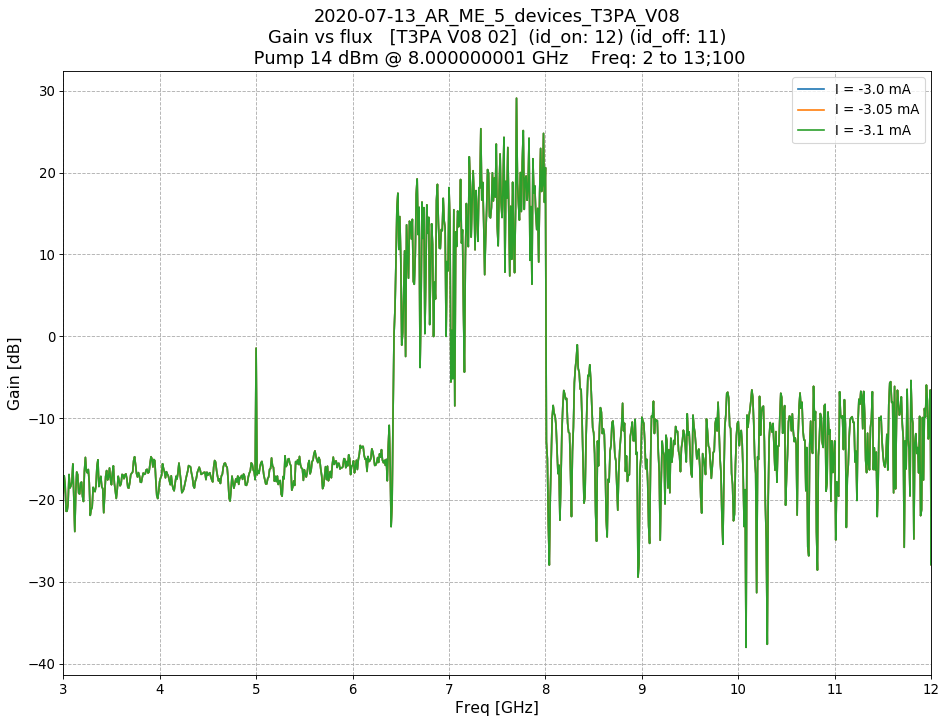

In [224]:
gain=magnitude_on-magnitude_off

plt.figure(figsize=(14, 10), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Freq [GHz]'
y_label='Gain [dB]'

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for current in current_list:
    plt.plot(freq_data,gain,label='I = '+str(current)+' mA')#marker="."
    
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.title(plot_title, size=16)

plt.legend(fontsize = 12)
plt.xlim(3, 12)
#plt.ylim(-6, 30)
plt.show()    